In [1]:
import numpy as np
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Text
from bokeh.io import output_notebook

In [2]:
n = 30
df = pd.read_csv("peng.csv")
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181,3750,male
1,Adelie,Torgersen,39.5,17.4,186,3800,female
2,Adelie,Torgersen,40.3,18.0,195,3250,female
3,Adelie,Torgersen,36.7,19.3,193,3450,female
4,Adelie,Torgersen,39.3,20.6,190,3650,male


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd

from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.models import PolyDrawTool, PolyEditTool
from bokeh.layouts import row
from bokeh.models import Label
from bokeh.models.widgets import Div

from hulearn.experimental.interactive import InteractiveClassifier, InteractiveChart

from bokeh.io import output_notebook

In [219]:
clf = InteractiveClassifier(df, labels="species")

Loading BokehJS ...

In [221]:
clf.add_chart(x="bill_length_mm", y="bill_depth_mm")

In [223]:
clf.add_chart(x="flipper_length_mm", y="body_mass_g")

In [224]:
import json 
import pathlib 

demo_data = clf.data()
pathlib.Path("demo_data.json").write_text(json.dumps(demo_data))

1988

In [225]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

point = Point(0.5, 0.5)
polygon = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])

In [226]:
data_in = {'bill_length_mm': 50.7, 'bill_depth_mm': 14.0, 'flipper_length_mm': 220.16, 'body_mass_g': 5500}
data = json.loads(pathlib.Path("demo_data.json").read_text())

def gen_poly_data(data):
    for chart in data:
        chard_id = chart['chart_id']
        labels = chart['polygons'].keys()
        coords = chart['polygons'].values()
        for lab, p in zip(labels, coords):
            x_lab, y_lab = p.keys()
            x_coords, y_coords = list(p.values())
            for poly in [Polygon(list(zip(x_coords[i], y_coords[i]))) for i in range(len(x_coords))]:
                yield {'x_lab': x_lab, 'y_lab': y_lab, 'poly': poly, 'label': lab, 'chart_id': chard_id}

def count_hits(clf_data, data_in):
    counts = {k: 0 for k in set(_['label'] for _ in clfd)}
    for c in clf_data:
        point = Point(data_in[c['x_lab']], data_in[c['y_lab']])
        if c['poly'].contains(point):
            counts[c['label']] += 1
    return counts

def fake_data(bill_length_mm=0.0, bill_depth_mm=0.0, flipper_length_mm=0.0, body_mass_g=0.0):
    return {'bill_length_mm': bill_length_mm, 'bill_depth_mm': bill_depth_mm, 'flipper_length_mm': flipper_length_mm, 'body_mass_g': body_mass_g}

In [227]:
clf_data = [_ for _ in gen_poly_data(data)]
count_hits(clf_data, data_in)

{'Adelie': 0, 'Gentoo': 2, 'Chinstrap': 0}

In [229]:
import numpy as np

class HumanClassifier:
    def __init__(self, json_desc):
        self.json_desc = json_desc
    
    def fit(self, X, y):
        self.classes_ = set(_['label'] for _ in self.json_desc)
        return self
    
    def predict(self, X):
        hits = [count_hits(self.json_desc, x[1].to_dict()) for x in X.iterrows()]
        count_arr = np.array([[h[c] for c in self.classes_] for h in hits])
        return count_arr/count_arr.sum(axis=1).reshape(-1, 1)


X, y = df[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]], df['species']
preds = HumanClassifier(clf_data).fit(X, y).predict(X)

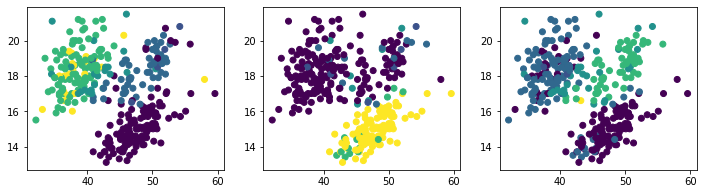

In [233]:
import matplotlib.pylab as plt 

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.scatter(X['bill_length_mm'], X['bill_depth_mm'], c=preds[:, 0])
plt.subplot(132)
plt.scatter(X['bill_length_mm'], X['bill_depth_mm'], c=preds[:, 1])
plt.subplot(133)
plt.scatter(X['bill_length_mm'], X['bill_depth_mm'], c=preds[:, 2])

In [38]:
p = figure(width=400, height=400)

colors = ["red", "blue", "green", "purple", "cyan"]
d = {k: col for k, col in zip(df['species'].unique(), colors)}
df['color'] = [d[lab] for lab in df['species']]
source = ColumnDataSource(data=df)

p.circle(x="bill_length_mm", y="bill_depth_mm", color="color", source=source)
show(p)

In [55]:
InteractiveChart(df, labels="species", x="bill_length_mm", y="bill_depth_mm").show()

In [7]:
clf.add_chart(x="bill_length_mm", y="bill_depth_mm")

In [14]:
clf.add_chart(x="flipper_length_mm", y="body_mass_g")

In [28]:
InteractiveChart(df, labels="species", x="bill_length_mm", y="bill_depth_mm").show()

In [33]:
InteractiveChart(df, labels="species", x="flipper_length_mm", y="body_mass_g").show()

In [12]:
from bokeh.layouts import column, row
from bokeh.models import Label
from bokeh.models.widgets import Paragraph, Div

glyph = Text(x="x", y="y", text="text")

def color_dot(name, color):
    dot = f"<span style='height: 15px; width: 15px; background-color: {color}; border-radius: 50%; display: inline-block;'></span>"
    return f"<p>{dot} {name}</p>"

class InteractiveChart:
    def __init__(self, dataf, labels, x, y):
        self.plot = figure(width=400, height=400, title=f'{x} vs. {y}')
        self.source = ColumnDataSource(data=dataf)
        self._colors = ["red", "blue", "green", "purple", "cyan"]
        if isinstance(labels, str):
            self.labels = list(dataf[labels].unique())
            self.plot.circle(x=x, y=y, color="gray", source=self.source)
        else:
            self.labels = labels
            self.plot.circle(x=x, y=y, color="gray", source=self.source)
        if len(self.labels) > 5:
            raise ValueError("We currently only allow for 5 classes max.")
        self.poly_patches = {}
        self.poly_draw = {}
        for k, col in zip(self.labels, self._colors):
            self.poly_patches[k] = self.plot.patches([], [], fill_color=col, fill_alpha=0.4, line_alpha=0.0)
            self.poly_draw[k] = PolyDrawTool(renderers=[self.poly_patches[k]], custom_icon=f"{col}.png")
        c = self.plot.circle([], [], size=5, color='black')
        edit_tool = PolyEditTool(renderers=list(self.poly_patches.values()), vertex_renderer=c)
        self.plot.add_tools(*self.poly_draw.values(), edit_tool)
        self.plot.add_layout(Label(x=70, y=70, text='here your text'))


    def app(self, doc):
        html = "<ul style='width:100px'>"
        for k, col in zip(self.labels, self._colors):
            html += f"<li>{color_dot(name=k, color=col)}</li>"
        html += "</ul>"
        doc.add_root(row(Div(text=html), self.plot))

    def show(self):
        show(self.app)
    
    @property
    def data(self):
        return {k: v.data_source.data for k, v in self.poly_patches.items()}

chart = InteractiveChart(df, labels="species", x="bill_length_mm", y="bill_depth_mm")

In [14]:
chart.show()

RuntimeError: no display hook installed for notebook type None

In [224]:
chart.data

{'Adelie': {'xs': [], 'ys': []},
 'Gentoo': {'xs': [], 'ys': []},
 'Chinstrap': {'xs': [], 'ys': []}}

In [10]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import PolyDrawTool, PolyEditTool

p = figure(width=400, height=400, title='HC')

source = ColumnDataSource(data=df)
p.circle(x='bill_length_mm', y='bill_depth_mm', color='gray', source=source)

p1 = p.patches([], [], fill_color='red', fill_alpha=0.4, line_alpha=0.0)
p2 = p.patches([], [], fill_color='green', fill_alpha=0.4, line_alpha=0.0)
p3 = p.patches([], [], fill_color='blue', fill_alpha=0.4, line_alpha=0.0)
c1 = p.circle([], [], size=5, color='black')

d1 = PolyDrawTool(renderers=[p1])
d1.custom_icon = "red.png"
d2 = PolyDrawTool(renderers=[p2])
d2.custom_icon = "green.png"
d3 = PolyDrawTool(renderers=[p3])
d3.custom_icon = "blue.png"

edit_tool = PolyEditTool(renderers=[p1, p2, p3], vertex_renderer=c1)
p.add_tools(d1, d2, d3, edit_tool)
p.toolbar.active_drag = edit_tool

def app(doc):
    global p
    doc.add_root(p)

show(app)

In [13]:
[_.data_source.data for _ in [p1, p2, p3]]

[{'xs': [[40.202167096441194,
    33.03309195193252,
    35.04393010222154,
    48.158091951932526,
    46.49696478430247]],
  'ys': [[21.341172332763673,
    18.68599991897057,
    15.367034401729189,
    17.331861987936087,
    20.438413712074016]]},
 {'xs': [[43.96156016002501,
    43.69927692303079,
    54.4528896397938,
    57.949999466383396,
    52.09234050684582,
    47.28381449528513]],
  'ys': [[18.000965760329674,
    15.452000243088294,
    17.07165541550209,
    20.576483001708986,
    21.24027610515726,
    19.594069208605536]]},
 {'xs': [[53.75346767447588,
    56.46372779008282,
    47.89580871493831,
    40.02731160511171,
    40.02731160511171,
    44.398698888348704,
    49.294652645574146]],
  'ys': [[17.62924162239864,
    15.55820713964002,
    11.802193073934946,
    13.16880351628064,
    14.824118902296433,
    16.26485636790277,
    17.368399958579968]]}]